In [1]:
import json
from typing import Optional

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


def calculate_gini(array: np.array) -> np.float64:
    """based on: https://github.com/oliviaguest/gini (CC0 1.0)"""
    # Values must be sorted:
    array = np.sort(array)
    # Index per array element:
    index = np.arange(1, array.shape[0] + 1)
    # Number of array elements:
    n = array.shape[0]
    # Gini coefficient:
    return np.round((np.sum((2 * index - n - 1) * array)) / (n * np.sum(array)), 4)


def calculate_multimodal_mean_pp(data: dict[str, float]) -> dict[str, Optional[float]]:
    result = {}
    for k, v in data.items():
        if len(v) > 0:
            result[k] = round(np.mean(v), 3)
        else:
            result[k] = None
    return result


def calculate_multimodal_mean_pp_as_dataframe(data: dict[str, float]) -> pd.DataFrame:
    result = calculate_multimodal_mean_pp(data)
    return pd.DataFrame(
        {
            "stop_id": list(result.keys()),
            "mean_price": list(result.values()),
        }
    )


colors = ["#41afaa", "#466eb4", "#00a0e1", "#e6a532", "#d7642c", "#af4b91"]

In [2]:
CITY = "budapest"
VERSION = "20250428"
FILTER = False

In [3]:
pp = pd.read_csv("~/PhD/dissertation/data/ingatlancom/cleaned_ingatlancom.csv")
pp = gpd.GeoDataFrame(pp, geometry=gpd.points_from_xy(pp["lon"], pp["lat"]), crs=4326)
pp = pp[["geometry", "norm_price"]].copy()

In [4]:
bp = gpd.read_file(f"../data/osm/{CITY}/boundary.geojson")

In [5]:
sgfw_raw = gpd.read_file(
    f"../output/{CITY}/{VERSION}/stop_geometries_from_walk.geojson"
)

- Data is from 2018.
- Contains real estate selling advertisements, not verified transactions.
- The raw data may include offices, building sites, industrial or agricultural estates.
- Outlier filtering: keep prices between 0.25 and 2.5 M HUF.

|property data descriptive     |number|percent|
|:-----------------------------|-----:|------:|
|number of records             | 87585|100.00%|
|points in Budapest            | 61981| 70.77%|
|points in 5-minute stop areas | 57549| 65.71%|
|filter between 0.25 and 2.5 M | 55994| 63.93%|


In [6]:
points_in_bp = pp[pp["geometry"].intersects(bp.geometry[0])]
points_in_area = sgfw_raw.sjoin(pp).drop_duplicates("index_right")

print(len(pp))
print(points_in_bp.shape[0])
print(points_in_area.shape[0])

87585
61981
57549


In [7]:
labels = [
    f"${f:0.2f}-{t:0.12}$"
    for f, t in zip(np.arange(0.25, 2.6, 0.25)[:-1], np.arange(0.25, 2.6, 0.25)[1:])
]
filtered_pp = points_in_area.copy()
if FILTER:
    filtered_pp = points_in_area[points_in_area["norm_price"].between(0.25, 2.5)].copy()
filtered_pp["Real estate price"] = pd.cut(
    filtered_pp["norm_price"],
    bins=np.arange(0.25, 2.6, 0.25),
    labels=labels,
    right=False,
    include_lowest=True,
)

In [8]:
q1 = filtered_pp.describe().loc["25%", "norm_price"]
q2 = filtered_pp.describe().loc["50%", "norm_price"]
q3 = filtered_pp.describe().loc["75%", "norm_price"]

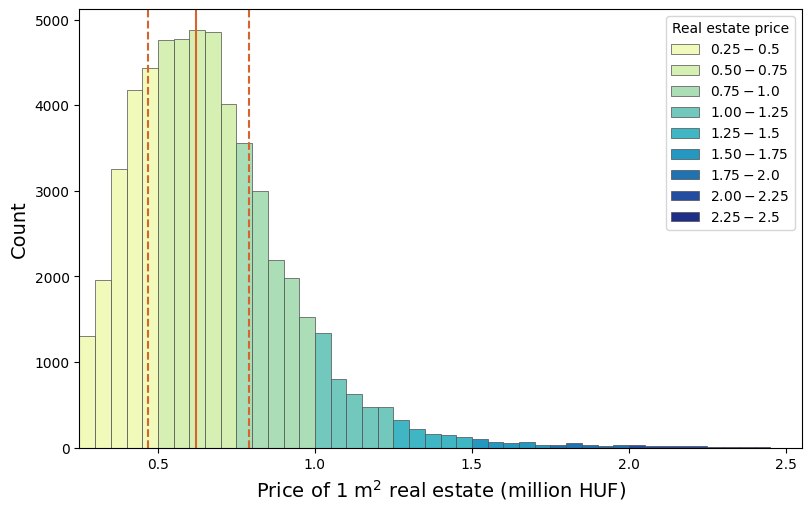

In [9]:
fig, ax = plt.subplots(figsize=(8, 5), layout="constrained")
sns.histplot(
    filtered_pp.sort_values("norm_price"),
    x="norm_price",
    palette="YlGnBu",
    edgecolor=".3",
    linewidth=0.5,
    bins=np.arange(0.25, 2.6, 0.05),
    hue="Real estate price",
    alpha=1,
    ax=ax,
)
ax.margins(0, 0.05)
ax.set_xlabel("Price of 1 m$^2$ real estate (million HUF)", fontsize=14)
ax.set_ylabel("Count", fontsize=14)
ax.axvline(q1, color="#d7642c", linestyle="dashed")
ax.axvline(q2, color="#d7642c", linestyle="solid")
ax.axvline(q3, color="#d7642c", linestyle="dashed")

In [10]:
sgfw = filtered_pp.drop("Real estate price", axis=1, errors="ignore").copy()

In [11]:
mean_price = sgfw.groupby(["stop_id"])["norm_price"].mean()

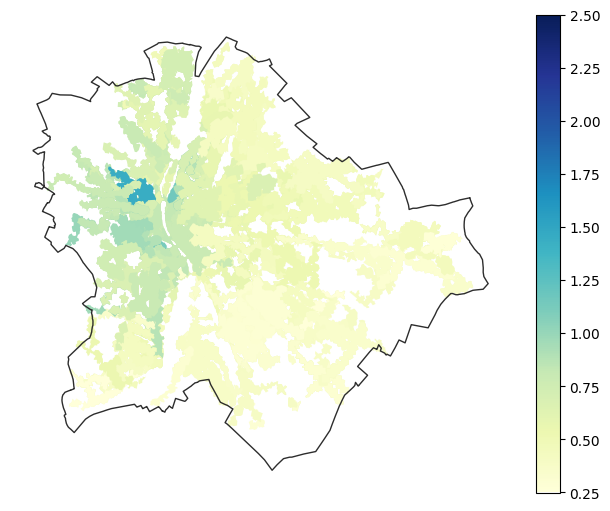

In [12]:
fig, ax = plt.subplots(figsize=(6, 5), layout="constrained")
sgfw.drop("norm_price", axis=1).drop_duplicates("stop_id").merge(
    mean_price, on="stop_id"
).plot(column="norm_price", legend=True, cmap="YlGnBu", ax=ax, vmin=0.25, vmax=2.5)
bp.plot(ax=ax, fc="none", ec="#2d2d2d")
ax.axis("off")
ax.margins(0.05)

According to [KSH](https://www.ksh.hu/stadat_files/lak/hu/lak0028.html):

- The mean price of 1 m^2^ resale apartments in Budapest in 2018: 0.508 M HUF
- The mean price of 1 m^2^ new apartments in Budapest in 2018: 0.603 M HUF

In [13]:
with open(f"../data/stops/{CITY}/{VERSION}/accessible_stops.json", "r") as fp:
    accessible_stops = json.load(fp)

In [14]:
result = {}
for stop, accessible in accessible_stops.items():
    result[stop] = sgfw[sgfw["stop_id"].isin(accessible)]["norm_price"].tolist()

In [15]:
with open(f"../output/{CITY}/{VERSION}/multimodal_pp.json", "w") as fp:
    json.dump(result, fp)

In [16]:
calculate_multimodal_mean_pp_as_dataframe(result).sort_values("stop_id").to_csv(
    f"../output/{CITY}/{VERSION}/stop_property_price.csv", index=False
)

In [17]:
stop_gini = {}
for k, v in result.items():
    stop_gini[k] = calculate_gini(np.array(v))

/tmp/ipykernel_24351/1750479806.py:20: RuntimeWarning: invalid value encountered in scalar divide
  return np.round((np.sum((2 * index - n - 1) * array)) / (n * np.sum(array)), 4)


In [18]:
with open(f"../output/{CITY}/{VERSION}/multimodal_stop_gini.json", "w") as fp:
    json.dump(stop_gini, fp)

In [19]:
with open(f"../output/{CITY}/{VERSION}/multimodal_stop_gini.json", "r") as fp:
    stop_gini = json.load(fp)

In [20]:
records = []
for k, v in stop_gini.items():
    records.append([k, v])
pd.DataFrame.from_records(records, columns=["stop_id", "multimodal_gini"]).sort_values(
    "stop_id"
).to_csv(f"../output/{CITY}/{VERSION}/multimodal_stop_gini.csv", index=False)

In [21]:
walk_accessibility = gpd.read_file(f"../output/{CITY}/{VERSION}/isochrones.geojson")
walk_accessibility = walk_accessibility.query("costing == 'walk' & range == 15").copy()
walk_accessibility = walk_accessibility.sjoin(pp).drop("index_right", axis=1)

In [22]:
walk15_gini = (
    walk_accessibility.groupby("stop_id")["norm_price"]
    .apply(calculate_gini)
    .reset_index()
)
walk15_gini.rename({"norm_price": "walk15_gini"}, axis=1, inplace=True)

In [23]:
walk15_gini.sort_values("stop_id").to_csv(
    f"../output/{CITY}/{VERSION}/walk15_stop_gini.csv", index=False
)